<a href="https://colab.research.google.com/github/Rashi203-codding/AI_DermaScan/blob/main/facial_aging_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

After running the above cell, you'll be prompted to authorize Google Drive access. Once authorized, your Drive will be mounted at `/content/drive`. You can then access your files. For example, to read a CSV file named `my_data.csv` located in the root of your Google Drive, you would use code like this:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -q albumentations==1.3.0 streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.5/123.5 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 91.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 90.8 MB/s eta 0:00:00


In [ ]:
import os

data_dir = "/content/drive/MyDrive/facial_aging_project/data"

classes = sorted(os.listdir(data_dir))
print("Classes found:", classes)


Classes found: ['clear_skin', 'dark_spots', 'puffy_eyes', 'wrinkles']


Showing samples for: clear_skin


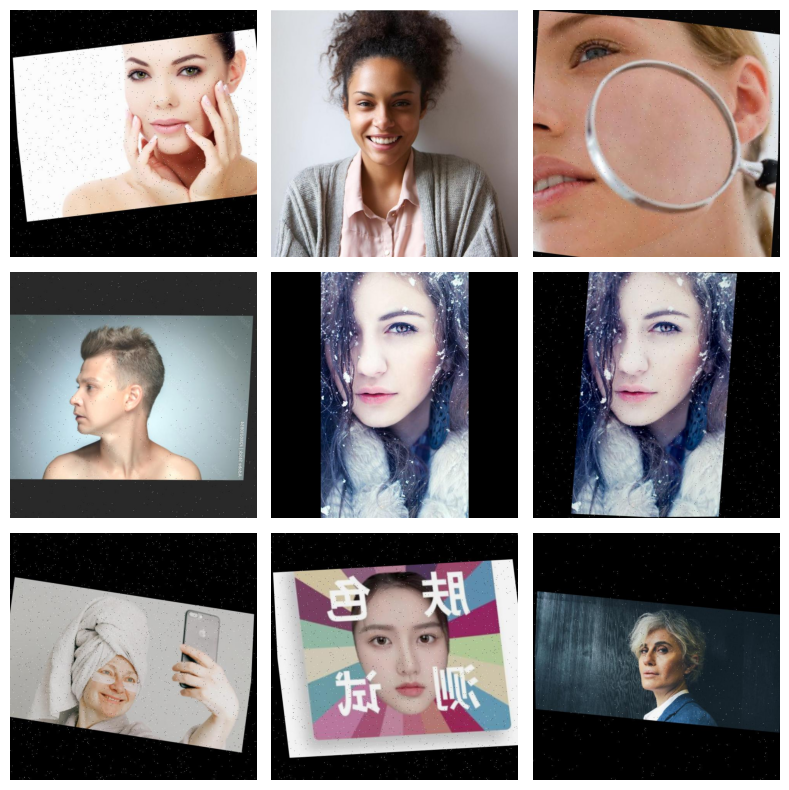

Showing samples for: dark_spots


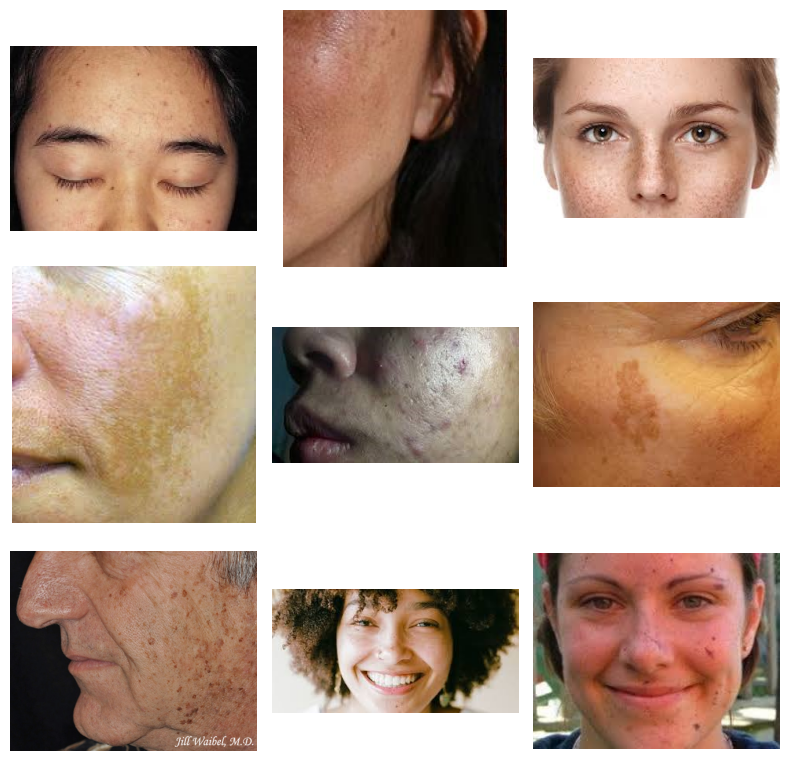

Showing samples for: puffy_eyes


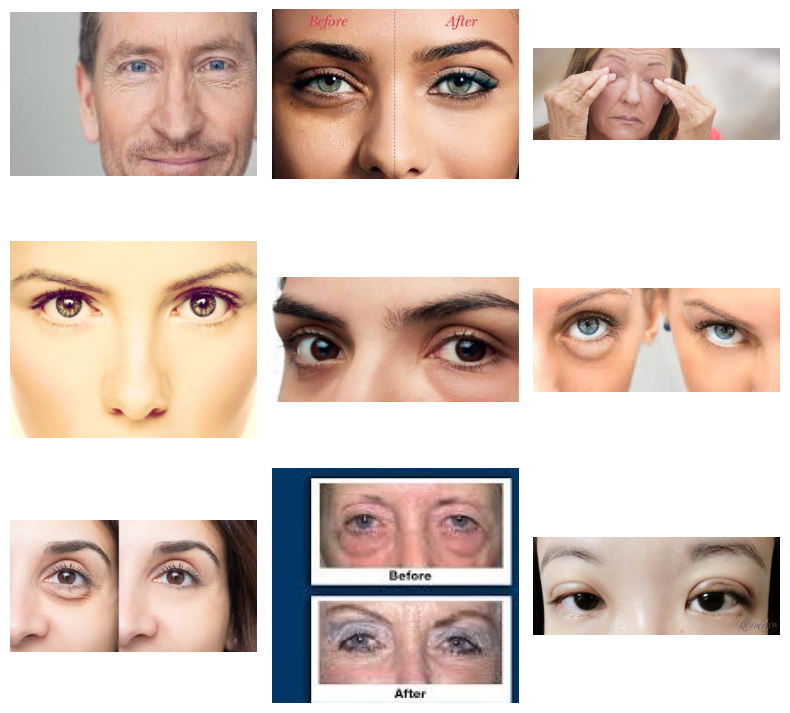

Showing samples for: wrinkles


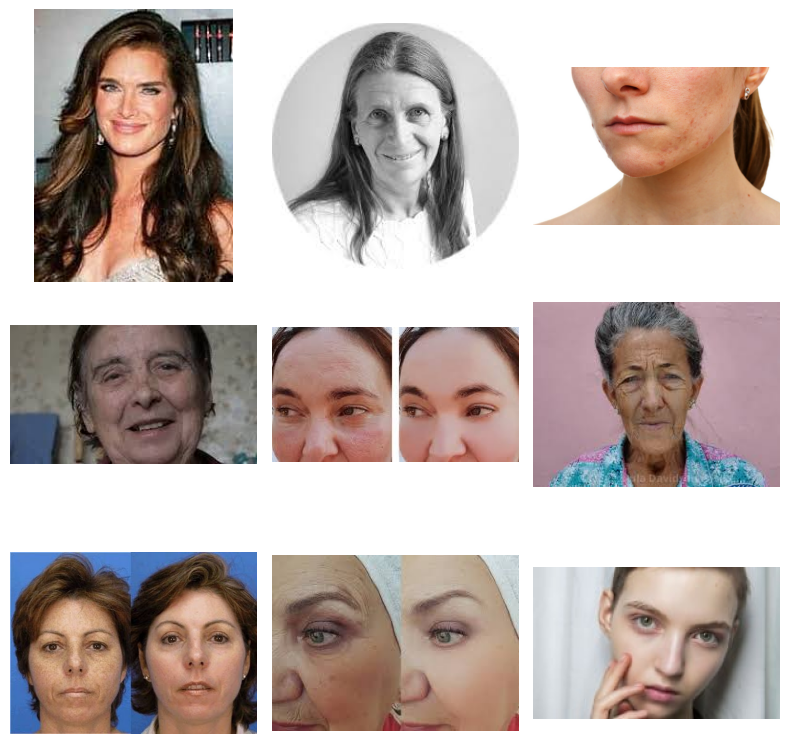

In [ ]:
import cv2
import glob
import matplotlib.pyplot as plt
import random

def show_samples(folder, n=9):
    files = glob.glob(os.path.join(folder, "*"))
    sample = random.sample(files, min(n, len(files)))

    plt.figure(figsize=(8,8))
    for i, f in enumerate(sample):
        img = cv2.imread(f)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(3,3,i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

for c in classes:
    print("Showing samples for:", c)
    show_samples(os.path.join(data_dir, c))


In [ ]:
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=25,
    zoom_range=0.2,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


In [ ]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)



In [ ]:
train = train_gen.flow_from_directory(
    data_dir,
    target_size=(224,224),
    class_mode='categorical',
    subset='training',
    batch_size=16,
    shuffle=True
)

Found 1075 images belonging to 4 classes.


In [ ]:
val = train_gen.flow_from_directory(
    data_dir,
    target_size=(224,224),
    class_mode='categorical',
    subset='validation',
    batch_size=16,
    shuffle=False
)


Found 267 images belonging to 4 classes.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

images, labels = next(train)
class_names = list(train.class_indices.keys())


In [ ]:
def deprocess_image(img):
    img = img.copy()
    img -= img.min()
    img /= img.max()
    img = (img * 255).astype("uint8")
    return img



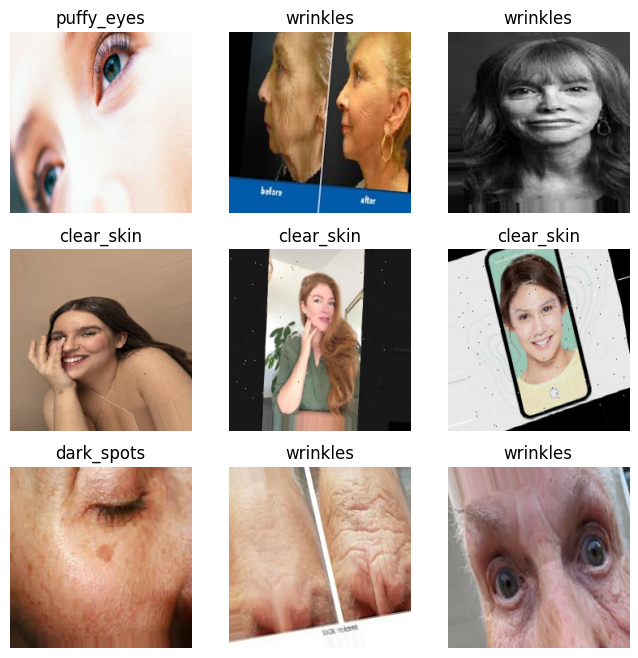

In [ ]:
plt.figure(figsize=(8,8))

for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(deprocess_image(images[i]))
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

plt.show()


In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


In [ ]:
base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

base_model.trainable = False



16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)



In [ ]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
history_1 = model.fit(
    train,
    validation_data=val,
    epochs=15
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.4833 - loss: 1.2243 - val_accuracy: 0.7715 - val_loss: 0.7813
Epoch 2/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step - accuracy: 0.7698 - loss: 0.7576 - val_accuracy: 0.8165 - val_loss: 0.6056
Epoch 3/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.8231 - loss: 0.5813 - val_accuracy: 0.8165 - val_loss: 0.5370
Epoch 4/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - accuracy: 0.8395 - loss: 0.4827 - val_accuracy: 0.8427 - val_loss: 0.4854
Epoch 5/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.8744 - loss: 0.4171 - val_accuracy: 0.8240 - val_loss: 0.4841
Epoch 6/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - accuracy: 0.8819 - loss: 0.4010 - val_accuracy: 0.8539 - val_loss: 0.4389
Epoch 7/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.8844 - loss: 0.3663 - val_accuracy: 0.8315 - val_loss: 0.4521
Epoch 8/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.9021 - loss: 0.3480 - val_accuracy: 0.8502 - v

In [ ]:
base_model.trainable = True

for layer in base_model.layers[:-20]:
    layer.trainable = False


In [ ]:
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
history_2 = model.fit(
    train,
    validation_data=val,
    epochs=5
)


Epoch 1/5
68/68 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.8026 - loss: 0.6484 - val_accuracy: 0.8315 - val_loss: 0.4080
Epoch 2/5
68/68 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 0.8470 - loss: 0.5334 - val_accuracy: 0.8764 - val_loss: 0.4237
Epoch 3/5
68/68 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.8589 - loss: 0.5096 - val_accuracy: 0.8577 - val_loss: 0.3963
Epoch 4/5
68/68 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.8597 - loss: 0.4832 - val_accuracy: 0.8577 - val_loss: 0.4237
Epoch 5/5
68/68 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.8641 - loss: 0.4705 - val_accuracy: 0.8577 - val_loss: 0.4029


In [ ]:
model.save('my_model.keras')

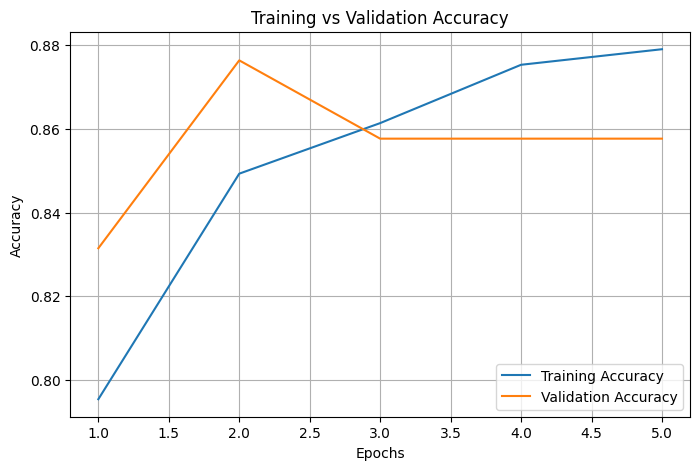

In [ ]:
import matplotlib.pyplot as plt

train_acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']

epochs = range(1, len(train_acc) + 1)

plt.figure(figsize=(8,5))
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.efficientnet import preprocess_input


In [ ]:
model = load_model("my_model.keras")


In [ ]:
face_cascade = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
)


In [ ]:
class_names = ['wrinkles', 'dark_spots', 'puffy_eyes', 'clear_skin']


In [ ]:
def detect_and_predict(img_rgb):
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

    faces = face_cascade.detectMultiScale(
        gray,
        scaleFactor=1.1,
        minNeighbors=3,
        minSize=(80, 80)
    )

    # ---- SMART FALLBACK (CENTER CROP) ----
    if len(faces) == 0:
        h, w, _ = img_rgb.shape
        size = min(h, w)
        cx, cy = w // 2, h // 2
        face = img_rgb[
            cy-size//2:cy+size//2,
            cx-size//2:cx+size//2
        ]
        faces = [(0, 0, face.shape[1], face.shape[0])]
    else:
        x, y, w, h = faces[0]
        face = img_rgb[y:y+h, x:x+w]

    face = cv2.resize(face, (224, 224))
    face = preprocess_input(face.astype("float32"))
    face = np.expand_dims(face, axis=0)

    preds = model.predict(face)[0]
    label_idx = np.argmax(preds)
    confidence = preds[label_idx] * 100

    return label_idx, confidence, preds


In [ ]:
!pip install gradio matplotlib



In [ ]:
import gradio as gr
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tempfile, csv, os, datetime
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.efficientnet import preprocess_input

# ================= LOAD MODEL =================
model = load_model("/content/my_model.keras")

class_names = ["Clear Skin", "Dark Spots", "Puffy Eyes", "Wrinkles"]

# ================= CSV LOG FILE =================
LOG_FILE = "prediction_logs.csv"

if not os.path.exists(LOG_FILE):
    with open(LOG_FILE, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["Timestamp", "Prediction", "Confidence (%)"])

# ================= SOLUTION LOGIC =================
def get_solution(label):
    solutions = {
        "Wrinkles": "Use retinol, moisturize daily, and apply sunscreen.",
        "Dark Spots": "Use Vitamin C serum and SPF protection.",
        "Puffy Eyes": "Improve sleep, reduce salt, and use cold compress.",
        "Clear Skin": "Maintain hydration and gentle skincare routine."
    }
    return solutions.get(label, "Maintain a healthy skincare routine.")

# ================= REPORT GENERATOR =================
def generate_report(label, confidence, preds):
    report = f"""
DERMALSCAN – FACE ANALYSIS REPORT
--------------------------------
Prediction : {label}
Confidence : {confidence:.2f} %

Detailed Probabilities:
"""
    for c, p in zip(class_names, preds):
        report += f"- {c}: {p*100:.2f}%\n"

    report += f"\nSuggested Care:\n{get_solution(label)}"

    tmp = tempfile.NamedTemporaryFile(delete=False, suffix=".txt")
    tmp.write(report.encode())
    tmp.close()
    return tmp.name

# ================= MAIN PREDICTION =================
def predict(image):
    img = cv2.resize(image, (224,224))
    img = preprocess_input(img.astype("float32"))
    img = np.expand_dims(img, axis=0)

    preds = model.predict(img, verbose=0)[0]
    label = class_names[np.argmax(preds)]
    confidence = float(np.max(preds) * 100)

    # Log prediction
    with open(LOG_FILE, "a", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([
            datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            label,
            f"{confidence:.2f}"
        ])

    # Plot
    fig, ax = plt.subplots(figsize=(6,4))
    bars = ax.bar(class_names, preds*100, color="#e53935")
    ax.set_ylim(0,100)
    ax.set_ylabel("Confidence (%)", color="white")
    ax.set_title("Prediction Confidence", color="white")
    ax.set_facecolor("#121212")
    fig.patch.set_facecolor("#121212")
    ax.tick_params(colors="white")

    for bar in bars:
        h = bar.get_height()
        ax.text(bar.get_x()+bar.get_width()/2, h+1, f"{h:.1f}%",
                ha="center", color="white")

    report_file = generate_report(label, confidence, preds)

    result_md = f"""
### 🔴 Prediction Result
**Detected Condition:** {label}
**Confidence:** {confidence:.2f} %

### 🩺 Suggested Care
{get_solution(label)}
"""

    return result_md, fig, report_file, LOG_FILE

# ================= AI ASSISTANT =================
def ai_assistant(question):
    q = question.lower()
    if "wrinkle" in q:
        return "Wrinkles are caused by aging and UV exposure. Use sunscreen and retinol."
    if "dark spot" in q:
        return "Dark spots come from pigmentation. Vitamin C and SPF help."
    if "puffy" in q:
        return "Puffy eyes improve with sleep and cold compress."
    return "I can help with skincare tips and understanding your results."

# ================= RED/BLACK CSS =================
custom_css = """
/* ================= GLOBAL ================= */
* {
    font-family: 'Segoe UI', sans-serif;
    color: #e0e0e0 !important;
}

/* ================= ANIMATED BACKGROUND ================= */
.gradio-container {
    background: linear-gradient(
        -45deg,
        #000000,
        #1a0000,
        #330000,
        #000000
    );
    background-size: 400% 400%;
    animation: gradientBG 15s ease infinite;
    padding: 30px;
    min-height: 100vh;
}

/* Background animation */
@keyframes gradientBG {
    0% { background-position: 0% 50%; }
    50% { background-position: 100% 50%; }
    100% { background-position: 0% 50%; }
}

/* ================= CARDS ================= */
.card {
    background: rgba(18, 18, 18, 0.85);
    padding: 22px;
    border-radius: 16px;
    border-left: 6px solid #e53935;
    box-shadow: 0 10px 30px rgba(0,0,0,0.7);
    margin-bottom: 20px;
    backdrop-filter: blur(6px);
}

/* ================= BUTTONS ================= */
.gr-button-primary {
    background-color: #e53935 !important;
    color: #ffffff !important;
    border-radius: 12px;
    font-weight: 600;
    box-shadow: 0 0 12px rgba(229,57,53,0.6);
}

.gr-button-primary:hover {
    box-shadow: 0 0 20px rgba(229,57,53,1);
    transform: scale(1.02);
    transition: 0.2s ease-in-out;
}

/* ================= HEADINGS ================= */
h1 {
    text-align: center;
    font-size: 56px;
    color: #ff5252 !important;
    text-shadow: 0 0 12px rgba(255,82,82,0.7);
}

.subtitle {
    text-align: center;
    font-size: 18px;
    color: #bdbdbd !important;
    margin-bottom: 20px;
}

/* ================= FILE / OUTPUT AREAS ================= */
.gr-file,
.gr-plot,
.gr-markdown {
    background: rgba(0,0,0,0.5);
    border-radius: 12px;
    padding: 10px;
}
"""


# ================= UI =================
with gr.Blocks(css=custom_css) as demo:

    gr.Markdown("""
    <h1>🔴 DERMALSCAN</h1>
    <div class="subtitle">AI Facial Skin Aging Detection System</div>
    """)

    with gr.Tabs():

        # -------- HOME --------
        with gr.Tab("🏠 Home"):
            gr.HTML("""
            <div class="card">
            <h3>🧬 About DermalScan</h3>
            <p>
            DermalScan is an AI-powered facial skin analysis system
            that detects aging signs using deep learning.
            </p>
            <ul>
                <li>Wrinkles</li>
                <li>Dark Spots</li>
                <li>Puffy Eyes</li>
                <li>Clear Skin</li>
            </ul>
            </div>
            """)

        # -------- DETECTION --------
        with gr.Tab("🔍 Detection"):
            with gr.Row():
                with gr.Column():
                    image_input = gr.Image(type="numpy", label="Upload Facial Image")
                    analyze_btn = gr.Button("Analyze Face", variant="primary")

                with gr.Column():
                    result_text = gr.Markdown(visible=False)
                    result_plot = gr.Plot(visible=False)
                    report_file = gr.File(visible=False, label="Download Analysis Report")
                    csv_file = gr.File(visible=False, label="Download Prediction Logs (CSV)")

            def wrapped_predict(img):
                text, plot, report, csvlog = predict(img)
                return (
                    gr.update(value=text, visible=True),
                    gr.update(value=plot, visible=True),
                    gr.update(value=report, visible=True),
                    gr.update(value=csvlog, visible=True),
                )

            analyze_btn.click(
                wrapped_predict,
                image_input,
                [result_text, result_plot, report_file, csv_file]
            )

        # -------- AI ASSISTANT --------
        with gr.Tab("🤖 AI Assistant"):
            gr.HTML("<div class='card'><h3>AI Skin Care Assistant</h3></div>")
            user_q = gr.Textbox(placeholder="Ask skincare related questions...")
            bot_a = gr.Markdown()
            ask_btn = gr.Button("Ask")

            ask_btn.click(ai_assistant, user_q, bot_a)

        # -------- ABOUT --------
        with gr.Tab("ℹ️ About"):
            gr.HTML("""
            <div class="card">
            <p><b>Project:</b> DermalScan</p>
            <p><b>Domain:</b> AI & Computer Vision</p>
            <p><b>Model:</b> EfficientNet</p>
            <p><b>Platform:</b> Google Colab + Gradio</p>
            </div>
            """)

demo.launch()



/tmp/ipython-input-1557011645.py:193: DeprecationWarning: The 'css' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'css' to Blocks.launch() instead.
  with gr.Blocks(css=custom_css) as demo:


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://553839e9c504c55975.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
def preprocess_image(image):
    image = cv2.resize(image, (224, 224))
    image = preprocess_input(image.astype("float32"))
    image = np.expand_dims(image, axis=0)
    return image


In [ ]:
def run_inference(model, image):
    preds = model.predict(image, verbose=0)[0]
    label_idx = np.argmax(preds)
    confidence = float(preds[label_idx] * 100)
    return label_idx, confidence, preds


In [ ]:
def detect_face(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.2, 5)

    if len(faces) == 0:
        h, w, _ = image.shape
        return image, (0, 0, w, h)   # fallback full image

    x, y, w, h = faces[0]
    face = image[y:y+h, x:x+w]
    return face, (x, y, w, h)


In [ ]:
def backend_pipeline(image):
    face, bbox = detect_face(image)
    processed = preprocess_image(face)
    label_idx, confidence, preds = run_inference(model, processed)

    return {
        "label": class_names[label_idx],
        "confidence": confidence,
        "preds": preds,
        "bbox": bbox
    }


In [ ]:
import csv, os, datetime

LOG_FILE = "prediction_logs.csv"

def log_prediction(result):
    file_exists = os.path.isfile(LOG_FILE)

    with open(LOG_FILE, "a", newline="") as f:
        writer = csv.writer(f)
        if not file_exists:
            writer.writerow(["Timestamp", "Label", "Confidence", "BBox"])

        writer.writerow([
            datetime.datetime.now(),
            result["label"],
            f"{result['confidence']:.2f}",
            result["bbox"]
        ])


In [ ]:
def save_annotated_image(image, bbox, label, confidence):
    x, y, w, h = bbox
    annotated = image.copy()

    cv2.rectangle(annotated, (x,y), (x+w,y+h), (0,200,0), 2)
    cv2.putText(
        annotated,
        f"{label} ({confidence:.1f}%)",
        (x, y-10),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.8,
        (0,200,0),
        2
    )

    path = tempfile.NamedTemporaryFile(delete=False, suffix=".png").name
    cv2.imwrite(path, cv2.cvtColor(annotated, cv2.COLOR_RGB2BGR))
    return path


In [ ]:
def get_log_file():
    return LOG_FILE


In [ ]:
def full_predict(image):
    result = backend_pipeline(image)
    log_prediction(result)

    annotated_path = save_annotated_image(
        image,
        result["bbox"],
        result["label"],
        result["confidence"]
    )

    return (
        f"### 💚 Prediction: {result['label']}\nConfidence: {result['confidence']:.2f}%",
        annotated_path,
        LOG_FILE
    )
